# Ballistic Deposition with Relaxation
## Packages

In [1]:
include("../BallisticDeposition.jl")
using Plots, ColorSchemes, LaTeXStrings, Statistics, DelimitedFiles
import PyPlot as plt

## Configurations

In [2]:
figpath = "../../fig/ballistic-deposition/"
rcParams = plt.PyDict(plt.matplotlib["rcParams"])
rcParams["text.usetex"] = true

true

## Visualizing the Layers

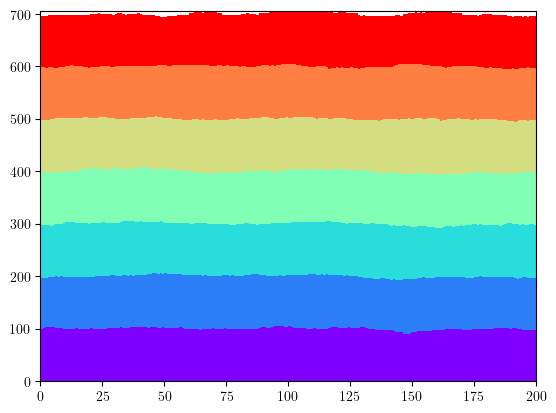

In [323]:
heights = BallisticDeposition.bdheights(BallisticDeposition.bdrelax!, 200,
    collect(Integer, range(20000, 140000, length=7)))
x = collect(range(0.5, 199.5, length=200))

fig, ax = plt.subplots()
ax.set_xlim(0, 200)
ax.set_ylim(0, maximum(heights))
rainbow = plt.get_cmap("rainbow")
for i in 7:-1:1
    ax.bar(x, heights[:, i], width=1, color=rainbow((i - 1) / 6), lw=0)
end

display(fig)
plt.savefig(figpath * "bd-relax-vis.pdf", bbox_inches="tight")

## Means

In [8]:
len, samples = 200, 20

times = collect(Integer, range(100 * len, 100 * len * samples, length=samples))
heights = BallisticDeposition.bdheights(BallisticDeposition.bdrelax!, len, times)
mean_heights = mean(heights, dims=1)'

intercept, slope = hcat(ones(samples), times) \ mean_heights
error = √(sum(x->x^2, mean_heights - slope * times .- intercept) / (samples - 2)
    / sum(x->x^2, times .- mean(times)))
print(slope, ' ', error)

0.005 5.807861132042741e-20

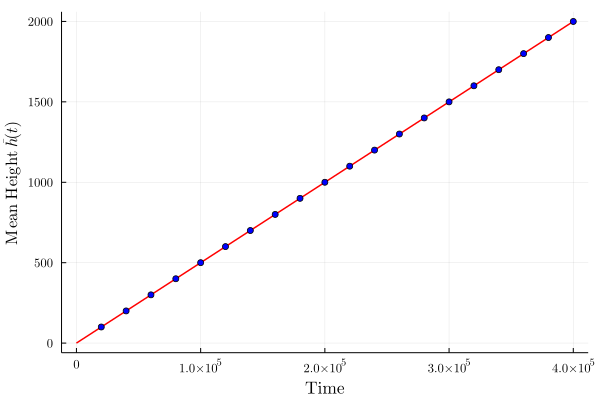

In [11]:
p = plot(x -> slope * x + intercept, 0, maximum(times), color=:red, lw=1.5,
    legend=false, fontfamily="Computer Modern",
    xlabel="Time", ylabel=L"\textrm{Mean \ Height} \ \bar{h}(t)")
scatter!(p, times, mean_heights, color=:blue)

display(p)
savefig(p, figpath * "bd-relax-mean.pdf")

## Roughness

In [3]:
# dictionaries mapping surface length to t_s and w_s for later use
tsdict, wsdict = Dict{Float64, Float64}(), Dict{Float64, Float64}()

(Dict{Float64, Float64}(), Dict{Float64, Float64}())

In [3]:
len, time, samples, runs = 200, 2 * 10^6, 100, 10000
times = [convert(Integer, ceil(ℯ^t)) for t in range(log(5 * len), log(time), length=samples)]

100-element Vector{Int64}:
    1000
    1080
    1166
    1260
    1360
    1468
    1586
    1712
    1849
    1996
    2155
    2327
    2513
       ⋮
  859506
  928096
 1002159
 1082132
 1168487
 1261734
 1362421
 1471144
 1588543
 1715310
 1852194
 2000000

In [7]:
# generate new data
heights = [BallisticDeposition.bdheights(BallisticDeposition.bdrelax!, len, times) for run in 1:runs]
roughness = mean([std(height, dims=1) for height in heights])'
σroughness = std([std(height, dims=1) for height in heights])'

# save data to file
open("bd-relax-data/bd-relax-$len.txt", "w") do io
    writedlm(io, [times roughness σroughness])
end

In [4]:
# load Data from file
data = readdlm("bd-relax-data/bd-relax-$len.txt")
times, roughness, σroughness = data[:, 1], data[:, 2], data[:, 3]

([1000.0, 1080.0, 1166.0, 1260.0, 1360.0, 1468.0, 1586.0, 1712.0, 1849.0, 1996.0  …  1.002159e6, 1.082132e6, 1.168487e6, 1.261734e6, 1.362421e6, 1.471144e6, 1.588543e6, 1.71531e6, 1.852194e6, 2.0e6], [0.975774318475063, 0.9948728575041305, 1.0147248450455204, 1.0340788325413797, 1.0533167835631818, 1.0725961905694528, 1.093853622367347, 1.114818678159905, 1.13625240990781, 1.157983221821671  …  3.1372161115561443, 3.154299473887718, 3.122271374067728, 3.128633640999734, 3.139247750661402, 3.149551902638908, 3.15906914976181, 3.147503253252792, 3.160384578303561, 3.134282913645407], [0.08309251362792204, 0.08634743000127904, 0.09030730820909308, 0.09319794405477207, 0.0970575750177742, 0.10066479121464149, 0.10503853976891392, 0.10817156719617065, 0.11258528818798362, 0.11586606143524522  …  0.946781846445064, 0.9548172319219117, 0.9341011198322976, 0.9419922083345297, 0.9510512246567407, 0.9567665820415019, 0.9624596140712945, 0.951989891495586, 0.9468777998995582, 0.9563421024694378])

In [5]:
timelog, roughlog = log.(times), log.(roughness)

r = 1 # coefficient of determination
maxlin = 2 # the last point for the roughness trend line
beta, coeff = undef, undef
while r > 0.999
    maxlin += 1
    beta, coeff = hcat(timelog[1:maxlin], ones(maxlin)) \ roughlog[1:maxlin]
    r = √(1 - sum(x->x^2, roughlog[1:maxlin] - beta * timelog[1:maxlin] .- coeff)
        / sum(x->x^2, roughlog[1:maxlin] .- mean(roughlog[1:maxlin])))
end
println(maxlin)

ϵ = 0 # residuals; we don't use r here because the line is nearly flat
minflat = samples - 1 # the first point for the flat trend line after saturation
flatness, wslog = undef, undef
while ϵ < 0.015
    minflat -= 1
    flatness, wslog = hcat(timelog[minflat:end], ones(samples - minflat + 1)) \ roughlog[minflat:end]
    ϵ = √sum(x->x^2, roughlog[minflat:end] - flatness * timelog[minflat:end] .- wslog)
end
println(minflat)

error = √(sum(x->x^2, roughlog[1:maxlin] - beta * timelog[1:maxlin] .- coeff) / (maxlin - 2)
    / sum(x->x^2, timelog[1:maxlin] .- mean(timelog[1:maxlin])))
print(beta, ' ', error)

59
82
0.2235971395151473 0.0013355093331729813

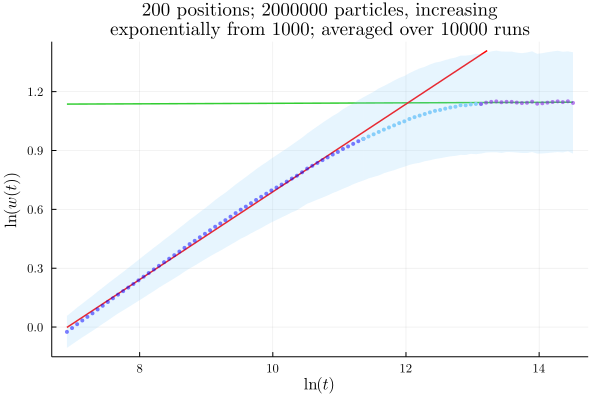

In [6]:
errorbar = σroughness ./ roughness - (σroughness ./ roughness).^2 ./ 2

# plot the trendlines
p = plot(x -> flatness * x + wslog, timelog[1], timelog[end], color=:limegreen, lw=1.5)
plot!(p, x -> beta * x + coeff, timelog[1],
    maximum(roughlog + errorbar .- coeff) / beta, color=:red, lw=1.5,
    xlabel=L"\mathrm{ln}(t)", ylabel=L"\mathrm{ln}(w(t))",
    title="$len positions; $time particles, increasing\n"
    * "exponentially from $(len * 5); averaged over $runs runs",
    legend=false, titlefontsize=12, fontfamily="Computer Modern")

scatter!(p, timelog[1:maxlin], roughlog[1:maxlin], ribbon=errorbar[1:maxlin],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:blue, markeralpha=0.5,
    markersize=2.3, markerstrokewidth=0)
scatter!(p, timelog[maxlin:minflat], roughlog[maxlin:minflat], ribbon=errorbar[maxlin:minflat],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:lightskyblue, markersize=2.3, markerstrokewidth=0)
scatter!(p, timelog[minflat:end], roughlog[minflat:end], ribbon=errorbar[minflat:end],
    fillcolor=:lightskyblue, fillalpha=0.2, markercolor=:blueviolet, markeralpha=0.6,
    markersize=2.3, markerstrokewidth=0)

savefig(p, figpath * "bd-relax-roughness-$len.pdf")
display(p)


In [54]:
tsdict[len] = ℯ^timelog[minflat]
wsdict[len] = ℯ^wslog
println(tsdict)
println(wsdict)

Dict(200.0 => 502161.0000000003, 50.0 => 8550.000000000007, 25.0 => 837.0000000000001, 12.0 => 108.00000000000003, 100.0 => 63042.00000000002)
Dict(200.0 => 3.0890542662387785, 50.0 => 1.5346686961735065, 25.0 => 1.0783359764959626, 12.0 => 0.7593642845505069, 100.0 => 2.180552455539836)


## Saturation

In [4]:
# run after adding all ts and ws to the respective dictionaries
ts = sort(collect(values(tsdict)))
ws = sort(collect(values(wsdict)))
ls = sort(collect(keys(tsdict)))
tslog = log.(ts)
wslog = log.(ws)
lslog = log.(ls)

5-element Vector{Float64}:
 2.4849066497880004
 3.2188758248682006
 3.912023005428146
 4.605170185988092
 5.298317366548036

In [5]:
z, coeffz = hcat(lslog, ones(length(ts))) \ tslog
error = √(sum(x->x^2, tslog - z * lslog .- coeffz) / (length(ts) - 2)
    / sum(x->x^2, lslog .- mean(lslog)))
print(z, ' ', error)

3.0240779011721957 0.04405343541930913

In [6]:
alpha, coeffa = hcat(lslog, ones(length(ls))) \ wslog
error = √(sum(x->x^2, wslog - alpha * lslog .- coeffa) / (length(ws) - 2)
    / sum(x->x^2, lslog .- mean(lslog)))
print(alpha, ' ', error)

0.5004882610747664 0.003269313758272206

In [7]:
betanew, coeffb = hcat(tslog, ones(length(ts))) \ wslog
error = √(sum(x->x^2, wslog - betanew * tslog .- coeffb) / (length(ts) - 2)
    / sum(x->x^2, tslog .- mean(tslog)))
print(betanew, ' ', error)

0.16542104730954496 0.002047189712144981

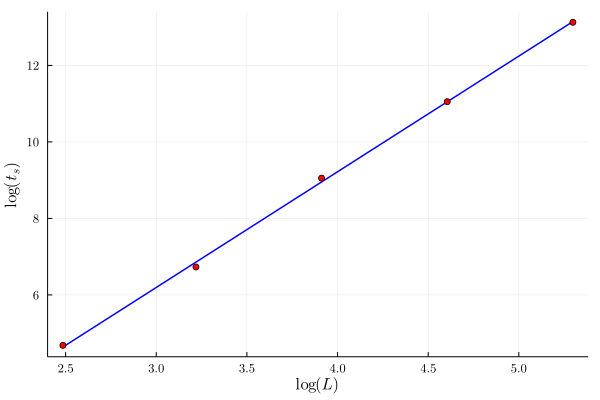

In [15]:
p = plot(x -> z * x + coeffz, lslog[1], lslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(L)", ylabel=L"\mathrm{log}(t_s)", fontfamily="Computer Modern")
scatter!(p, lslog, tslog, color=:red)

savefig(p, figpath * "bd-relax-sat-z.pdf")
display(p)

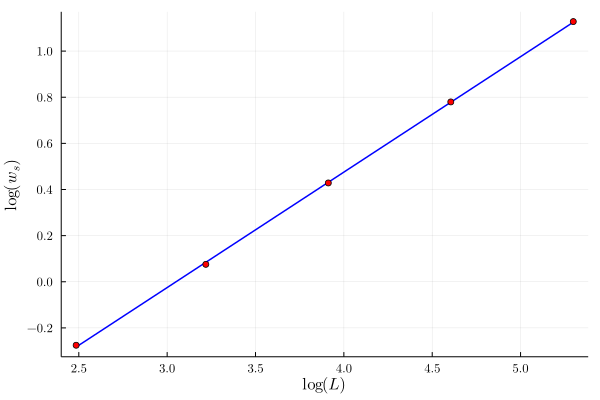

In [16]:
p = plot(x -> alpha * x + coeffa, lslog[1], lslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(L)", ylabel=L"\mathrm{log}(w_s)", fontfamily="Computer Modern")
scatter!(p, lslog, wslog, color=:red)

savefig(p, figpath * "bd-relax-sat-alpha.pdf")
display(p)

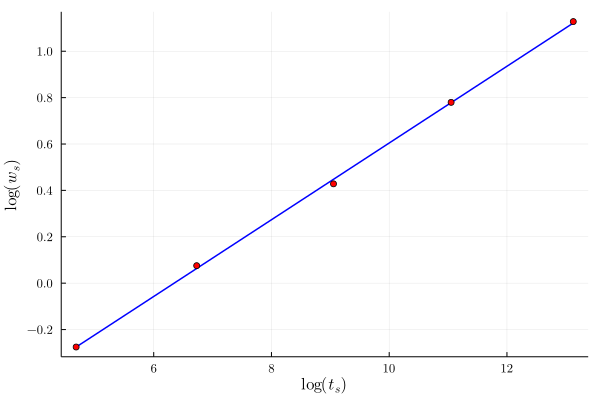

In [17]:
p = plot(x -> betanew * x + coeffb, tslog[1], tslog[end], color=:blue, lw=1.5, legend=false,
    xlabel=L"\mathrm{log}(t_s)", ylabel=L"\mathrm{log}(w_s)", fontfamily="Computer Modern")
scatter!(p, tslog, wslog, color=:red)

savefig(p, figpath * "bd-relax-sat-beta.pdf")
display(p)